# BACKTESTING: EW vs CW

Backtesting lets you test the waters by checking if you invest in one way, what would you get? It is a great way to test strategies.

In [1]:
import numpy as np
import pandas as pd

import risk_kit as kit
%load_ext autoreload
%autoreload 2

Load industry portfolios for 49 different industries

In [2]:
def get_ind_returns(weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios Monthly Returns
    """
    return get_ind_file("returns", weighting=weighting, n_inds=n_inds)

In [3]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype == "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype == "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype == "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

In [4]:
def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_nfirms(n_inds=n_inds)
    ind_size = get_ind_size(n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    #else
    return ind_mktcap

In [5]:
def get_ind_nfirms(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms", n_inds=n_inds)

In [6]:
def get_ind_size(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size", n_inds=n_inds)

In [7]:
# Load industry portfolios for 49 different industries. 
# In factor analysis, value-weighting and cap-weighting is used synonymously. Here value means the market-value or market-cap.
ind49_returns = get_ind_returns(weighting="vw", n_inds=49)["1974":]   # cap-weighted
ind49_mcap = get_ind_market_caps(49, weights=True)["1974":]

In [8]:
def weight_ew(r):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame.
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

In [9]:
# Backtest a weighting scheme.
def backtest_ws(ret, estimation_window=60, weighting=weight_ew, verbose=False, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r: asset returns used to build the portfolio.
    estimation window: the window used to estimate parameters.
    weighting: the weighting scheme to use, must be a function that takes "r" and a variable number of keyword arguments.
    """
    n_periods = ret.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the integer location of the start and stop 
    weights = [weighting(ret.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # Convert list of weights to DataFrame
    weights = pd.DataFrame(weights, index=ret.iloc[estimation_window-1:].index, columns=ret.columns)
    returns = (weights * ret).sum(axis="columns", min_count=1) # min_count is to generate NAs if all inputs are NAs
    return returns
    

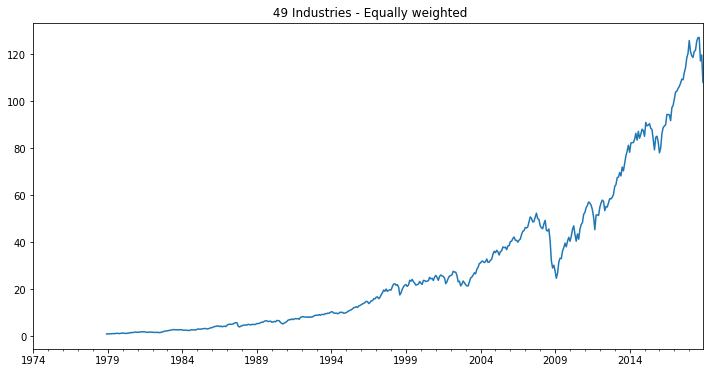

In [10]:
eq_weight_return = backtest_ws(ind49_returns, weighting=weight_ew)
# Convert to a wealth index
eq_wealth_index = (1+eq_weight_return).cumprod()
eq_wealth_index.plot(figsize=(12,6), title=" 49 Industries - Equally weighted")

Now, consider Cap-weighted. Capweights are already provided through the marketcap file.

In [11]:
def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    return cap_weights.loc[r.index[1]]

In [12]:
# Tweak the code to take weighting as arguments
def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert list of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

In [13]:
def weight_ew(r, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)


,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
CW,0.119761,0.147661,-0.726933,5.621768,0.065773,0.093909,0.591491,-0.516647


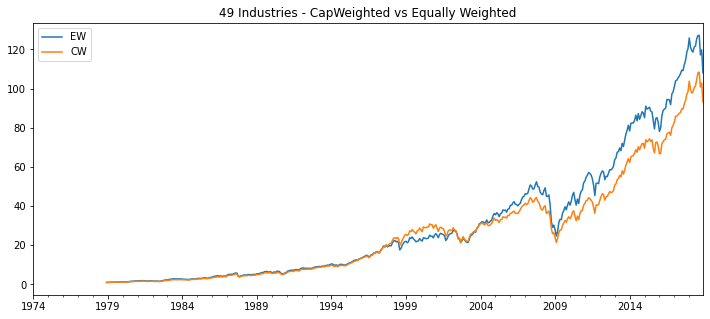

In [14]:
eq_weighted_ret = backtest_ws(ind49_returns)
cap_weighted_ret = backtest_ws(ind49_returns, weighting=weight_cw, cap_weights=ind49_mcap)
back_test_return = pd.DataFrame({"EW":eq_weighted_ret, "CW":cap_weighted_ret})
(1+back_test_return).cumprod().plot(figsize=(12,5), title="49 Industries - CapWeighted vs Equally Weighted")
kit.summary_stats(back_test_return.dropna())

For this particular time period for the portfolios considered, the Sharpe Ratio advantage was not there for Equally weighted.

#### Improving EW with Cap Weight Tethering

In practice, no one implements an equally weighted portfolio. It is very tricky to implement. The two main reasons are:

    1. If you literally weight things, that means you have to take huge positions in tiny companies. So if they have a very small market-cap, you very often simply cannot hold as much of that company as you can of IBM or APPLE, the large companies. SO if the market cap of a company is less than 1% of the portfolio, people will just drop it to reduce transaction costs etc.
  
    2. The second adjustment is that people frequently take an equally weighted portfolio and tie it back to their cap-weighted portfolio in some way. This is saying, I don't want to have a weight in say Stock-X, that is more than some multiple of what I would have had if it were cap-weighted.
    
    
These two modifications to equally-weighted portfolio makes it a bit more cap-weighted like and the great thing that comes out of this is that - you can ***reduce tracking error***.

Often in practice, we'll want to implement some sort of a modification of a pure strategy. For instance, although Equal Weight portfolios are popular, they'll be constrained in some way - for instance to match the sector weights of the cap-weighted benchmark or to make sure that microcap stocks are not overweighted. The motivation for doing so could be to make a portfolio more tradeable (e.g. some microcaps may not have the liquidity) or to improve the tracking error to the Cap-Weighted index.

As an illustration of how that can be achieved, we enhance our simple weight_ew allocator to (i) drop microcap stocks beyond a particular threshold, and (ii) impose a constraint that ensures that the maximum weight assigned to any stock is no more than some multiple of the weight it would be in a cap-weighted portfolio.

In [15]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[1]]
    return w/w.sum()

def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns


,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
EW-Tethered,0.125572,0.156923,-0.752967,6.187433,0.069778,0.099191,0.592597,-0.530654
CW,0.119761,0.147661,-0.726933,5.621768,0.065773,0.093909,0.591491,-0.516647


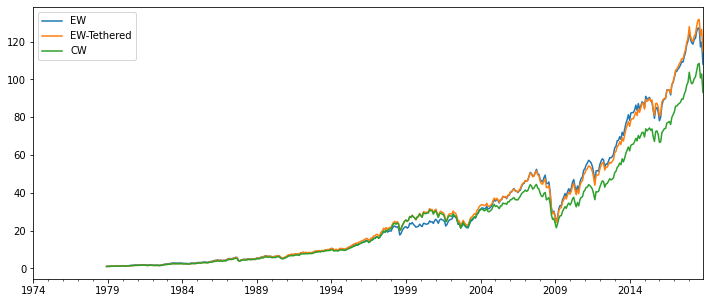

In [16]:
eq_weighted_ret = backtest_ws(ind49_returns)
eq_weighted_tethered_ret = backtest_ws(ind49_returns, cap_weights=ind49_mcap, max_cw_mult=5, microcap_threshold=.005)
cap_weighted_ret = backtest_ws(ind49_returns, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": eq_weighted_ret, "EW-Tethered": eq_weighted_tethered_ret, "CW": cap_weighted_ret})
(1+btr).cumprod().plot(figsize=(12,5))
kit.summary_stats(btr.dropna())

In this case, it gave you a slightly higher return. But the real reason to do this is to reduce tracking error.

In [17]:
kit.tracking_error(eq_weighted_ret, cap_weighted_ret),kit.tracking_error(eq_weighted_tethered_ret, cap_weighted_ret)

(0.23248147494738433, 0.1553623086424526)

There is very significant decrease in tracking error by implementing the constraints.